In [4]:
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

from importlib import reload
import pickle as pkl

import sys
sys.path.append("../include/")
import hhsignal
import hhtools

import power_utils as pu
reload(pu)

<module 'power_utils' from '/home/jungyoung/Project/hh_neuralnet/figures/power_utils.py'>

In [2]:
# Load summary obj
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data", load_only_control=True)
print(summary_obj.num_controls)

with open("../extract_osc_motif/data/osc_motif/amp_range_set.pkl", "rb") as fp:
    motif_data = pkl.load(fp)

amp_range_set = motif_data["amp_range_set"]

[10, 800]


**Check the change of power spectrum with connection**

**Track the change of powers as increasing motif threshold**

In [495]:
cid = 4
nid_power = 2
nlevel = 10

params_spec = dict(mbin_t=0.01, wbin_t=0.5)

zpsd_seg = [[] for _ in range(nlevel)]
amp_range = amp_range_set[cid-1]
# nt = 0

for nt in range(800):
    detail = summary_obj.load_detail(cid-1, nt)
    pline, tpsd, psd_dict = pu.get_spec_line(detail, amp_range, params_spec=params_spec)
    pline = pu.norm_minmax(pline)

    p = pu.digitize(pline[nid_power], nlevel)
    seg = pu.identify_long_seg(p, min_len=int(0.2/params_spec["mbin_t"]))

    zpsd = psd_dict["psd"]
    zpsd = (zpsd - zpsd.mean(axis=2, keepdims=True)) / zpsd.std(axis=2, keepdims=True)

    for n0, n1, pid in seg:
        zpsd_seg[pid].append(np.swapaxes(zpsd[:,:,n0:n1], 0, 2))

for pid in range(nlevel):
    if len(zpsd_seg[pid]) == 0: continue
    zpsd_seg[pid] = np.concatenate(zpsd_seg[pid], axis=0)

In [506]:
fpsd = psd_dict['fpsd']
zpsd_im = np.zeros((nlevel, len(fpsd), 2))
for nlv in range(nlevel):
    zpsd_im[nlv] = np.median(zpsd_seg[nlv], axis=0)

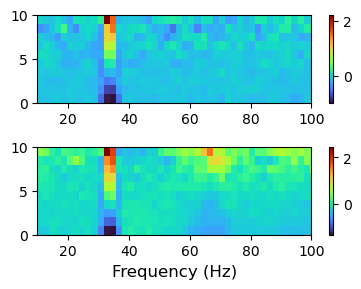

In [507]:
plt.figure(figsize=(4, 3))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.imshow(zpsd_im[:,:,i], aspect="auto", cmap="turbo", origin="lower",
              extent=(fpsd[0], fpsd[-1], 0, nlevel))
    plt.xlim([10, 100])
    plt.colorbar()

    
plt.xlabel("Frequency (Hz)", fontsize=12)
    
plt.tight_layout()
plt.show()

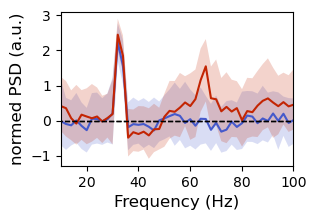

In [512]:
c = [plt.get_cmap("turbo")(0.1), plt.get_cmap("turbo")(0.9)]
nlv = 9

fpsd = psd_dict["fpsd"]
plt.figure(figsize=(3, 2))
for i in range(2):
    # m = zpsd_seg[nlv][...,i].mean(axis=0)
    
    # s = zpsd_seg[nlv][...,i].std(axis=0)
    # y1 = m - 2.58*s/np.sqrt(zpsd_seg[nlv].shape[0])
    # y2 = m + 2.58*s/np.sqrt(zpsd_seg[nlv].shape[0])
    
    m = np.median(zpsd_seg[nlv][...,i], axis=0)
    y1 = np.percentile(zpsd_seg[nlv][...,i], 25, axis=0)
    y2 = np.percentile(zpsd_seg[nlv][...,i], 75, axis=0)
    
    plt.plot(fpsd, m, c=c[i])
    plt.fill_between(fpsd, y1, y2, alpha=0.2, color=c[i], edgecolor=None)
    plt.hlines(0, 0, 100, color='k', linestyle='--', linewidth=1)
    
plt.xlim([10, 100])
    
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("normed PSD (a.u.)", fontsize=12)
plt.show()

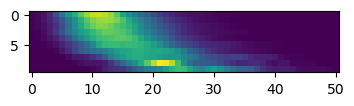

In [524]:
from scipy.ndimage import gaussian_filter1d

idf = (fpsd >= 60) & (fpsd < 70)

nbins = 51
nbin_set = np.zeros((nlevel, nbins))

for nlv in range(nlevel):
    zpsd_seg_sub = zpsd_seg[nlv][:,idf,1].mean(axis=1)
    y, e = np.histogram(zpsd_seg_sub, bins=np.linspace(-1.5, 3, nbins+1))
    nbin_set[nlv, :] = gaussian_filter1d(y, 1)
    
prob = nbin_set / nbin_set.sum(axis=1, keepdims=True)
    
plt.figure(figsize=(4, 3))
plt.imshow(prob)
plt.show()

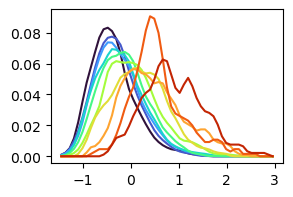

In [527]:
cmap = plt.get_cmap("turbo")
x = (e[1:] + e[:-1])/2

plt.figure(figsize=(3, 2))
for i in range(10):
    plt.plot(x, prob[i], c=cmap(i/10))
plt.show()

In [367]:
amp_range

{'fpop': [array([31.33, 35.27]), array([50.65, 68.84])],
 'spop': [array([30.22, 35.97]), array([50.72, 65.06])]}

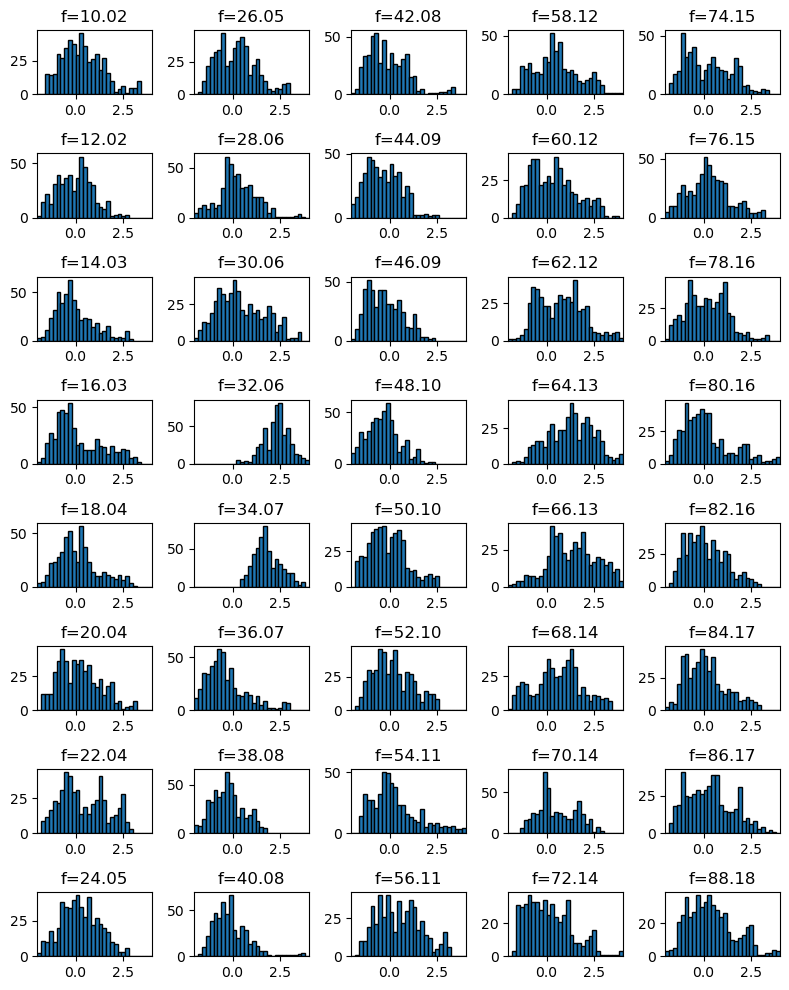

In [391]:
n0 = 2
# plt.figure(figsize=(8, 6))
fig, axs = plt.subplots(8, 5, figsize=(8, 10))
for i in range(5):
    for j in range(8):
        plt.sca(axs[j][i])
        plt.hist(zpsd_seg[9][:,n0,1], np.linspace(-2, 4, 31), edgecolor='k')
        plt.title("f=%.2f"%(fpsd[n0]))
        plt.xlim([-2, 4])
        n0 += 1

plt.tight_layout()        
plt.show()

In [345]:
np.sum((fpsd >= 10) & (fpsd < 90))

40

In [359]:
fpsd[25]

56.11222444889779

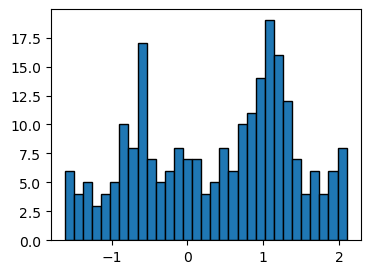

In [369]:
plt.figure(figsize=(4, 3))
plt.hist(zpsd_seg[9][:,25,1], 31, edgecolor='k')
plt.show()